# EEG-ERP Preprocessing
---
## Learning Objectives
- Be able to describe the standard steps in preprocessing EEG data for ERP analysis, including filtering, visual inspection, automated artifact detection and removal using independent components analysis, bad channel removal and interpolation, re-referencing, and averaging
- Be able to describe the motivation for each of these preprocessing steps
- Be able to perform each preprocessing step using MNE

---

## Introduction
**Preprocessing** is a series of signal processing steps that are performed on data prior to analysis (EDA and/or statistical analysis) and interpretation. In virtually all forms of neuroimaging data, including EEG and MEG, preprocessing is necessary in order to remove noise and obtain a clean signal of interest. In the case of EEG, the data recorded from the scalp are inevitably a mixture of signals generated from the brain (which we likely care about), and other signals generated by sources other than the brain (which we generally don't wish to interpret). 

When they first learn about preprocessing, some people think it sounds a lot like cheating — "doctoring" or "cooking" the data to engineer a specific pattern of desired results. This is *not* the case, however. Preprocessing steps are carefully designed and implemented based on our understanding of the source and nature of particular sources of noise, as well as our understanding about the nature of the electrical activity generated by the brain. Because the skull is such a poor conductor of electricity, the amplitude of EEG signals recorded from the scalp is very small. In contrast, the amplitude of signals from noise sources — especially from the muscles and eyes — are often an order of magnitude or more larger. Thus if we fail to remove these known sources of noise from the data, it would be unlikely that we would detect the brain activity at all, and at best our ability to do so and make valid interpretations would be greatly diminished. In other words, ***preprocessing is an essential step in EEG analysis***.

In this lesson we will describe each standard step in preprocessing EEG data for ERP analysis, including why it is done, and how, using the MNE package. A script that runs a series of preprocessing steps on data is often called a **piepline**; often this term is used to also include the entire proces from transferring data from the EEG system to a server or other long-term storage, preprocessing, and statistical analysis. The present script is an example of a **preprocessing pieline**.

### Sources of noise in EEG

In EEG, sources of noise can be physiological and non-physiological.

**Physiological** sources of noise include muscles (especially face and neck muscles, which generate electrical potentials when contracting and relaxing), the eyes (which create distinctive signals both during blinks, and when the eyeballs move), and sometimes heartbeats (the heart produces strong, distinctive electrical signals as commonly measured with the electrocardiogram, or EKG) and breathing; the latter two sources typically are more of a problem for MEG than EEG data.

**Non-physiological** sources include artifacts generated when electrodes move relative to the scalp, when the electrode wires move, and ambient electromagnetic noise. Electromagnetic noise is created by virtually any device that uses electricity (except some battery-powered devices). In North America and some other parts of the world, **line voltage** — the alternating current that is provided through wired electrical outlets — oscillates at 60 Hz; in Europe and other parts of the world, line voltage alternates at 50 Hz. Thus depending on where the EEG data were recorded, they will likely contain a fairly distinct peak in the frequency spectrum at 50 or 60 Hz. While line noise is the most common source of electromagnetic interference, noise at other frequencies can also be produced by other equipment near the neuroimaging system (though sometimes this may be in another room or another floor of the building, and difficult to identify), or even stronger, transient sources (such as the 2-way radio of a passing truck).

We commonly refer to particular types of noise from known sources as **artifacts** in EEG. Thus you may see reference to *eye blink artifact*, *line noise artifact*, etc.. 

---

## Load packages

In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output

import numpy as np
import matplotlib.pyplot as plt

## Define experimental and preprocessing parameters

In the single unit chapter, we started the practice of defining experimental parameters as variables at the top of a notebook. This is good practice because the values are then defined when you need them. As well, it's good practice to define all of these parameters at the top of the file, rather than in the cell where you first need to use them. This is because, if later you want to change a parameter and re-run your notebook, it's easy to find all of the parameters, rather than scrolling through the script to find them. As well, when you report your results (e.g., in the Methods section of a paper), many of these parameters are things that you should include in your report. Defining them all at the top of a script makes it easy to find these values when you're writing up your study. 

<div class="alert alert-block alert-info">
<h3>Best practices in EEG/MEG reporting</h3>
    
Especially for people who are new to any field of neuroimaging, there can be an overwhelming array of technical information relating to how the data were collected, preprocessed, and analyzed. This can make it challenging to know how, or what, to report. Fortunately, leaders in the field have reached a general consensus on this, and have published guidelines for reporting EEG and MEG study results. The most recent of these is from [Pernet and colleagues (2020)](https://www.nature.com/articles/s41593-020-00709-0) and is endorsed by the Organization for Human Brain Mapping.    
    
</div> 

Below we define all the parameters we'll use in this preprocessing script. We'll explain them in more detail as we reach each step in the preprocessing pipeline.

In [2]:
# Participant ID code
p_id = 'N400_dataset_14'

## Import raw data

This is just the same as in the previous lesson

In [3]:
raw_file = 'data/' + p_id + '.vhdr'

raw = mne.io.read_raw_brainvision(raw_file, preload=True)

## Set electrode positions

In [4]:
# Electrode position file
montage = 'standard_1005'

In [5]:
raw.set_montage(montage)

<RawBrainVision | N400_dataset_14.eeg, 16 x 623850 (1247.7 s), ~76.2 MB, data loaded>

## Filtering

As described in the previous section on [Time and Frequency Domains](./time_freq), a complex time-varying signal like EEG can be represented as a combination of sine waves of many different frequencies. Human EEG largely comprises signal power in a range of frequencies from 1–30 Hz; there is some evidence that higher frequencies may also carry important neurophysiological information, however in most EEG studies — and certainly in ERP studies — the vast majority of research questions concerns EEG signals in the 1–30 Hz frequency range. 

Sources of noise also manifest as oscillating frequencies that are picked up by EEG. In particular, *low frequency noise* comes from sources such as movement of the head and electrode wires, and perspiration on the scalp, while *high frequency noise* comes from sources including electromagnetic interference, and muscle contractions (especially facial and neck muscles). The frequency of these sources of noise may overlap with the 1-30 Hz EEG nad of interest, but in general they tend to be lower and higher, respectively, than human EEG. This means that by reducing the power of the signal at the frequencies above and below the range of experimental interest, we can reduce noise with minimal impact on the signals of interest. This process is called **filtering**.

Filtering typically occurs at two points in the EEG pipeline: first at the time the data are recorded, and secondly during preprocessing. When EEG data are collected, the EEG amplifier will at the very least have a filter that cuts off frequencies that are higher than a certain threshold. This is called the **low pass filter cutoff**, because the filter "passes" lower frequencies through, but attenuates (reduces) higher frequencies. A low pass filter is absolutely *necessary* during digital recording of EEG (or any signal), because of a phenomenon known as **aliasing**. This occurs when a high-frequency signal is sampled at a rate lower than the frequency of the signal, and the result is an artifact (an artificial signal that distorts our true signal) at a much lower frequency than the actual high-frequency source. 

### Aliasing

Simply knowing that aliasing causes high-frequency noise to be represented in the data as low-frequency artifacts — and that for this reason it's e to use a low-pass filter — is the most critical thing for someone doing EEG research. However, it's good to understand this phenomenon a little deeper. 

For example, in the current data set the EEG was recorded with a sampling rate of 500 Hz, meaning we obtained a measurement from each electrode every 2 ms. This is a sufficient sampling rate to detect an EEG signal at 30 Hz, because over the course of each cycle of the 30 Hz oscillation (e.g., from one peak to the next), which would last 1/30th of a second, we would have 500 / 30  $\approx$ 17 measurements of the waveform — so we should have enough samples to accurately reflect the shape of the oscillating sine wave. 

In contrast, imagine that during the recording, there was an electromagnetic (noise) signal present in the environment that oscillated at 1700 Hz. Thus in 1 second, the noise signal would have 1700 oscillations, but our EEG amplifier could not detect this, since it is only sampling 500 times per second. In fact, 3.4 oscillations of the noise waveform would occur between every sample acquired by the EEG amplifier. Since 1700 is not an even multiple of 500, each sample acquired by our EEG amplifier would also capture a different phase of the 17000 Hz oscillation — sometimes its peak, sometimes its trough, and sometimes somewhere in between. When we "connect the dots" between these samples to draw our measured EEG signal, these measurements at different points in the oscillation will end up looking like a much lower-frequency oscillation. **This is shown in the figure below.**

![aliasing figure]()

The highest frequency that one can accurately record at a given sampling rate is called the **Nyquist frequency**. This can be defined as either 1/2 or 1/3 of the sampling rate. In general, you should use 1/3 because it is safest. Using 1/2 is acceptable only if you can guarantee that your noise sources and your signal are *phase locked*, meaning (in a simplified way) that their peaks and troughs are synchronized with each other. Since we can't guarantee this in real-world situations where noise is unpredictable, the 1/3 rule should be used.

### Offline filtering

**Offline** is a term that is generally used in EEG to refer to processing steps that are applied after the data are collected, in contrast to **online** processing that is applied when data are collected. So, the low-pass filter used during recording to prevent aliasing is an example of an online filter, while filtering that we apply in a script like this is offline filtering. 

Offline filtering serves to remove more noise from the data than online filtering. In general, EEG researchers prefer to record with a wider range of filter settings, in part because filters can cause distortions to the data, particularly if the cutoffs are too close to the range of frequencies of interest. Any online filter that is applied to the data is permanent, since the data are originally recorded that way — there is no "undo" option. In contrast, with offline filtering one can apply different filters and observe the results on the data, and re-load the original data and use different filter settings if necessary. 

### Offline filter settings

We defined our filter cutoffs in the parameters section above, and the settings used are pretty standard in the world of ERP analysis: a high-pass (low frequency) cutoff of 0.1 Hz, and a low-pass (high frequency) cutoff of 30 Hz (some researchers use 40 Hz instead). Together, this is called a **band pass filter**, because we preseve a "band" of frequencies between e high-pass and low-pass cutoffs. 

tse settings strike an optimal balance between attenuating artifacts outside the range of human EEG signals of interest, without inducing artifacts of their own. These artifacts typically occur if the filter cutoffs are too close to the range of frequencies of scientific interest. It turns ou that the high-pass cutoff needs to be much lower (by a factor of about 10) than the lowest frequency of interest (hence 0.1 when our lowest frequency of interest is 1 Hz), while the low-pass cutoff can be much closer to the highest frequency of interest (in most ERP research, components of interest are rarely higher than about 10 Hz).

### Always filter first

Filtering should always be one of the first preprocessing steps you apply to your data. Most importantly, filtering should be applied to the continuous, raw EEG data before it is chopped into short segments time-locked to the event codes of interest. This is because we need long segments of data in order to accurately estimate and remove low frequencies. For example, our low frequency cutoff of 0.1 Hz corresponds to one sine wave oscillation every 10 sec, and we would need 20-30 s of data to estimate this accurately. A typical segment of data for ERP analysis is only about 1-2 s long at most, and so once your data are segmented, you can't remove low frequencies. Even for high frequencies, filtering results in removing the first and last few data points from the data (for technical reasons we won't cover here), and so again it's better to filter at the start and not worry about it later.

MNE provides a `.filter()` method for `Raw` data that is simple to apply, but is actually very powerful because of the many options provided. If you're interested in more detailed discussion of how filtering works, both in general and in MNE, their website has a very detailed [discussion of filtering](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html).

### Plot the frequency spectrum of the raw data

MNE's `.plot_psd()` method plots the **power spectral density** (PSD) of a data set. *Power* refers to the amplitude of sine waves when we are working in the frequency domain, *spectrum* means a range of frequencies, and *density* basically means we're quantifying the power over a range of frequencies. In a sense, you can think of a PSD as a histogram of frequency information — frequency is a continuous variable that is divided into bins (bin size is determined automatically), and the amount of power is plotted for each frequency bin. We set the `fmax` kwarg to 100 because we aren't interested in frequencies above this.

MNE automatically colour-codes electrodes based on their position on the scalp, as shown in the inset to the figure, and the lines in the PSD represent the data from each corresponding electrode. 

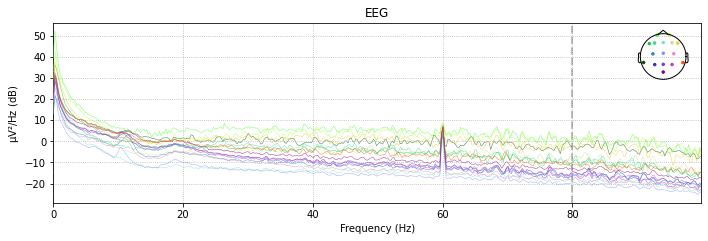

In [6]:
raw.plot_psd(fmax=100);

The PSD shows a clear spike at 60 Hz, which is the frequency of AC electrical service in Canada, where the data was recorded. This is the electromagnetic interference mentioned above.

The PSD also shows a typical property of human EEG (and many other kinds frequency spectra), known as the **1 / *f*** property. That is, power is highest at the lowest frequencies, and drops off with increasing frequency. The dropoff is not linear (a diagonal line), but rather decreases at approximately 1 divided by the frequency. 

The vertical dashed line shows the low-pass cutoff that was used during data acquisition. This information was stored in the EEG header file, and read by MNE when the data was imported.

### Filter the raw data

We need to chain the `.copy()` and `.filter()` methods because by default, the `.filter()` method modifies the raw data in-place, rather than creating a new, filtered copy of the data. This is sensible for managing the memory used, but can create problems if we want to change the filter settings and redo the filtering step. 

All of the parameters used for filtering were defined at the top of this notebook.

In [7]:
# Filter settings
low_cut = 0.1
hi_cut  = 30
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'
filter_method = 'fir'

In [8]:
raw_filt = raw.copy().filter(low_cut, hi_cut,
                             l_trans_bandwidth = l_trans_bandwidth,
                             h_trans_bandwidth = h_trans_bandwidth,
                             filter_length=filter_length,
                             method=filter_method)

### Plot the frequency spectrum of the filtered data


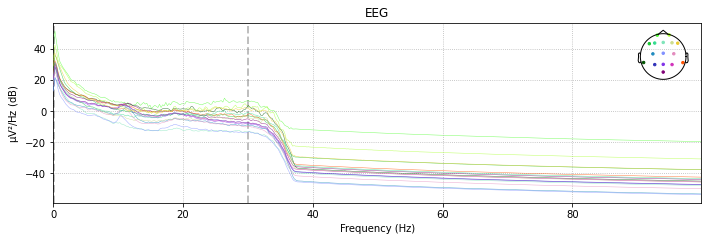

In [9]:
raw_filt.plot_psd(fmax=100);

The effects of our low-pass filter are quite evident — in comparison to the pre-filtering PSD, there is a dramatic drop in power above our 30 Hz cutoff (note that the dashed line has moved to reflect our new low-pass cutoff). The spike at 60 Hz is gone (actually it's still there, but very small), because the filtering virtually eliminated this noise from the data. 

The effects of the high-pass filtering are much harder to see, since the scale is linear from 0–100 Hz, but our cutoff of 0.1 Hz was very close to zero. If we set `fmax` to 10 we can see the effects of the high-pass cutoff more clearly:

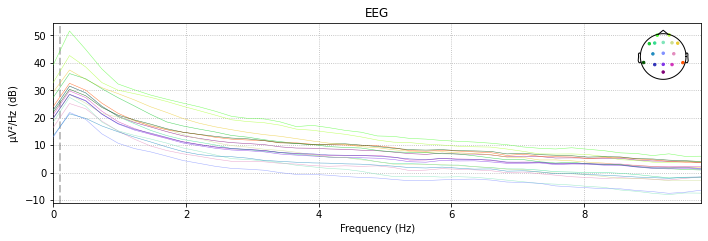

In [10]:
raw_filt.plot_psd(fmax=10);

Note that for both the high- and low-pass filters, the power does not drop of sharply right at the cutoff frequency we specified. Rather, there is a **roll-off** — a range of frequencies over which the power gradually decreases. The shape of the roll-off is a property of the filter that is determined by its parameters, and some roll-off is a necessary feature of any filter if aftifacts are to be avoided. Again, this is a deep topic that we won't delve into here, but in general it is useful to remember the adage that *precision in the frequency domain is inversely related to precision in the time domain*. In other words, if we use a sharper frequency cutoff, we are likely to induce larger artifacts in the data, when we view the filtered data in the time domain. 

### Visualizing the effects of filtering in the time domain

Below we plot 5 s of data, comparing the raw and filtered versions.

#### Unfiltered

Note the high frequency noise in virtually all channels — the oscillations that occur very rapidly. This is particularly large in channel F8. This is primarily 60 Hz line noise. 

Channels F8 and Fp2 show low frequency noise as well — these are the slow drifts up and down seen in these channels.

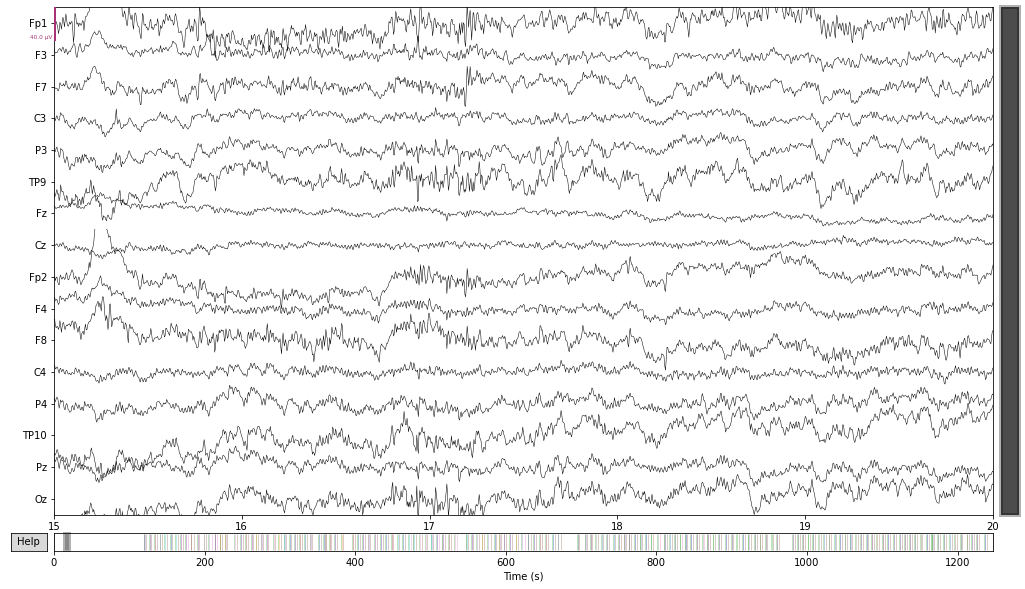

In [11]:
raw.plot(start=15, duration=5);  # times are in seconds

#### Filtered

The plot below shows the same sample of data after filtering. The high frequency noise is gone. The low-frequency noise is perhaps a bit reduced, but not eliminated. This is because our high-pass filter setting was 0.1 Hz, which means that only frequencies below 1 cycle per 10 sec would be reduced. These are so slow that we would not even see much evidence of them in 5 sec of data. Although we could filter the data with a higher high-pass cutoff (e.g., 1 Hz instead of 0.1 Hz), this risks inducing artifacts into the data ([Tanner, Morgan-Short, & Luck, 2015](https://doi.org/10.1111/psyp.12437)), so we don't. 

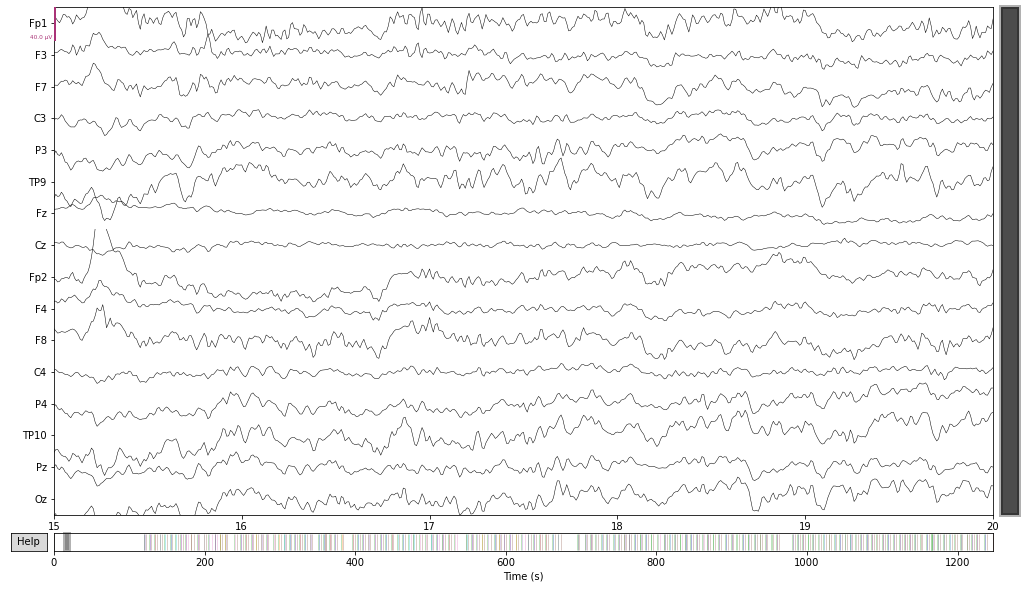

In [12]:
raw_filt.plot(start=15, duration=5);

## Artifacts in EEG Data

Recall that the term **artifact** in EEG refers to any noise in the data that can be attributed to a specific source. So eye blinks, eye movements, and muscle contractions are all types of artifacts. It is important to remove these from the data, to increase our confidence that the results we ultimately interpret are actually due to brain activity, and not these other sources.

Common physiological artifacts, including eye blinks, eye movements, and muscle contractions, have highly characteristic properties in time and frequency. Examples of each are shown below:

### Eye blink

There are a series of several eye blinks in the data below, the first at 242 s. You can see that the size of eye blink artifacts are typically on the order of 10x as large as ongoing EEG, which is why they are such a problem. Note that we have scaled the amplitude scale (*y* axis) of the EEG data differently than in the plots above, so that the ongoing EEG is quite flat, and the blinks stand out more clearly.

<img src='images/eog_blink.png' width=400>

Because the artifact originates at the eyes, is is picked up most strongly by the electrodes on the forehead, Fp1 and Fp2, as well as other frontal electrodes (the ones whose labels start with *F*, though much smaller). The electrical potential sharply increases, then decreases, over a period of about 250-300 ms for a typical blink. The artifact actually *inverts* at more posterior electrodes, for example at TP9 and TP10 in the figure above. These are the characteristic properties of an eye blink artifact, which can be used to identify them.  

### Eye movements

The neurons in the retina are organized in a highly oriented fashion, such that they form an electrical **dipole** — a source with positive and negative poles. This is exactly the kind of electrical source that EEG is good at detecting. As long as the eye's position doesn't change, the diploe created by the retina doesn't affect EEG recordings, because it is constant (not changing). However, as the eye moves to look at different locations in space, the dipole moves, and this is detected by the electrodes on the scalp. When they eyes move to the left or right, the effect on EEG electrodes is that the electrical potential will increase at frontal electrodes on one side of the head, and decrease on the other side. Which side becomes more positive or negative depends on the direction of the movement. 

An example of a horizontal eye movement is shown in the figure below, overlapping the time where the vertical green line is shown (this line is an event marker, but this is irrelevant for our present purposes). At electrodes Fp1 and Fp2, the artifact looks very similar to a blink. However, note how there is a roughly "square wave" effect at electrodes F7 and F8 (and to a lesser extent, at F3 and F4), and that this goes positive at F7/F3, and negative at F8/F4. This is the hallmark of a horizontal eye movement artifact. In the example below, the horizontal eye movement is followed by two blinks. We can tell these are blinks because the polarity (direction of change) at both F7 and F8 is the same (positive/upward).

<img src='images/eog_horiz.png' width=200px>

### Muscle contractions

In the figure below, note the increase in high frequency activity starting just after 872 s, especially at channels F3, F7, and TP9. This is typical of a muscle contraction, likely of the face and/or neck. Brief contractions like this are usually not a problem, but if the participant is tense throughout the experiment, or at least for extended periods, then this high frequency noise can make it more challenging to detect ERPs. Muscle contractions typically have a fairly broad frequency range, from about 20-40 Hz, which means that this artifact will be present even after the data is band-pass filtered.

<img src='images/eeg_muscle.png' width=400px>

## Artifact removal with Independent Components Analysis (ICA)

ICA is a *blind source separation* algorithm. In other words, it can take a complex signal and separate it into mathematically independent *components*. Note that the term "components" here is not used in the sense of ERP components (like the N170 or N400) that were discussed earlier. Rather, in ICA *components* are the individual underlying signals that were mixed together during recording. So for example, in EEG each electrode will record a mixture of brain activity (which itself may comprise multiple sources within the brain, such as the activity of different brain areas) and noise (including physiological and non-physiological artifacts). ICA is capable of separating EEG from artifacts (and separating different types of artifacts) because, over time and across all of hte recording electrodes, each signal with a different source will have different spatio-temporal properties. 

A nice example of using ICA, that may seem a. bit less abstract than EEG data, is audio recording. Imagine that we have two people in a room having a conversation, and there is background noise in the room such as from the ventilation system. If we have a single microphone in the room, all three signals (person A, person B, and the ventilation) will be mixed in the recording and it will be hard to separate them. However, if we have three microphones at different locations in the room, then each will pick up all three sound sources, but to different degrees depending on the location of each microphone. ICA can use the audio from all three microphones to find independent sources in the data (i.e., person A, person B, and the ventilation), based on how the sounds from each person, and the ventilation, differ systematically across the three microphones. But this only works because we have multiple independent sources (the microphones) sampling the data from different locations.

Likewise with EEG, it is necessary to have multiple electrodes (the sources) to run ICA. The maximum number of ICA components  that can be derived from a data set is equal to the number of electrodes (channels) we have. However, in practice the number of independent sources in the data is lower than the number of electrodes, and we can limit the number of ICA components accordingly, as we'll see below. 

In EEG, ICA has become widely used for artifact identification and removal. This is because it does a very good job of identifying ocular artifacts (blinks and eye movements), and also usually muscle artifact as well. Moreover, because the different ICA components are mathematically independent of each other, having identified which components are "noise" (such as blinks), we can remove these components from the data without affecting the other components. This means we can effectively remove the effects of ocular artifacts from the data, while preserving the EEG signals. This is usually preferable to older approaches, such as removing any trial containing an artifact from the data set completely. ICA allows us to remove artifacts while keeping all of the trials. 

### Filter data for ICA

ICA is very good at capturing features of the data that explain the most *variance*. Recall that variance, statistically speaking, is any deviation from the mean. Blinks and eye movements are well-captured by ICA because they are so much larger than EEG, and so they contain a lot of the variance in the EEG recordings. Likewise, low-frequency drift in the data explains large amounts of variance, because of the 1/f property of EEG data discussed earlier — the lowest frequencies contain the most power. For this reason, ICA works best on data that has more low-frequency power removed than the data that we ultimately want to analyze. So we will filter the data for ICA with a 1 Hz high-pass cutoff, rather than a 0.1 Hz cutoff as we used above. A useful property of ICA is that we can compute ICA based on a more-filtered version of the data, identify the artifacts based on this, and then apply the same ICA decomposition (i.e., how ICA breaks the data down into components) to the data that were filtered as we wanted for ERP analysis. Below we do this, running the same filtering command as we did earlier, except with a different high-pass (low frequency) cut-off:

In [13]:
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power

raw_ica = raw.copy().filter(ica_low_cut, hi_cut,
                             l_trans_bandwidth = l_trans_bandwidth,
                             h_trans_bandwidth = h_trans_bandwidth,
                             filter_length=filter_length,
                             method=filter_method)

ICA likes to work with segments of data, rather than the continuous raw data. We call segments of EEG data **epochs**, a word which means "a period of time". Typically when talking about ERPs, *epochs* refers to the segments of data that are time-locked to experimental events of interest. Here, however, we use the term more generically to refer to any segment of EEG data. So here we will segment the entire raw data recording into a series of 1 s segments, and save these as `epochs_ica`.

In [15]:
# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Next we run a function from the autoreject package that will look at the data and automatically determine a threshold to use to find sections of the data that are excessively noisy:

In [16]:
from autoreject import get_rejection_threshold

### Find appropriate rejection threshold to eliminate noisy trials from ICA fitting
reject = get_rejection_threshold(epochs_ica);
reject

### Fit ICA to data

Running ICA on our data involves two steps: 
1. Create an `ICA` object with the parameters (kwargs) that we want to use
1. `fit` this object to the data — which effectively runs the algorithm on the data, using the parameters set in step 1

This may seem overly complex — why define and object and then apply a `.fit()` method, rather than having a method that we just apply to the data in a single step/line of code?  

The reason relates to the nature of object-oriented languages. By creating an `ICA` object, we have a data structure — separate from the EEG data itself — that stores important information about this preprocessing step. After we fit the `ICA` object to the data, the object contains the values that were estimated from the data. In other words, running `.fit()` on the data *doesn't change the data itself*, only the `ICA` object. That way, this step is "non-destructive" in the sense that if we aren't happy with the results, we don't need to worry about re-loading our data — we can simply modify parameters of the `ICA` object and re-fit it. We'll do this for ICA as well; later in the course we'll see that this is actually the primary way in which machine learning and statistical models are fit to data sets in Python. 

The first parameter that we want to specify is the number of independent components we want. Recall that by default, ICA will compute as many components as there are channels in the data, but this is typically more than is necessary or useful. The `n_components` parameter of ICA can be specified in one of two ways. One is to provide an integer specifying the actual number of components desired. An optimal number for this, however, is hard to know in advance. The other way is to specify a floating point number ≤ 1, which represents the percentage of data that the ICA components should, collectively, explain. Here we use `.99`, which means we want as many independent components as needed to explain 99% of the variance in the data. Typically this is a good value to use.

The other parameter is `random_state`. We use this because ICA is an *iterative* algorithm that starts with a set of random parameters, and then over a series of fitting steps computes the optimal values of these parameters. The set of random parameters it starts with determines the results to some extent. That is, if you fit ICA repeatedly to the data, you will generally get very similar, but not identical, results each time, because of the different random starting points. By specifying a `random_state`, we ensure that the same "random" parameters are used each time, meaning that our results will be replicable. The value 42 is used by convention, because it is the "Answer to the Ultimate Question of Life, the Universe, and Everything" in *The Hitchhiker's Guide to the Galaxy* (Adams, 1979).

In fitting ICA to the data, we include a couple of other parameters, which were defined earlier. `reject` comes from `get_rejection_threshold`, and `tstep` is the 1 s intervals that we segmented our data in. 

In [19]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)

Method,fastica
Fit,31 iterations on epochs (624747 samples)
ICA components,8
Explained variance,99.3 %
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


The `.fit()` step produces the output you see above, showing some of the resulting parameters stored in `ica`.

### Visualize ICA components


Every IC (an independent component identified by ICA) is a signal that varies over time, that has a "weighting" at each channel - reflecting how strongly present that IC is in that channel. In other words, the time course of an IC is the same at all electrodes, but it is bigger at some, and smaller at others. 

We can visualize each component as a **scalp topography map**, showing where on the scalp the IC is largest. *Topo maps*, as they are often abbreviated, are a different way of visualizing EEG data than we've seen before. Whereas previously we've viewed EEG as electrical potential over time, topo maps show how the potential are distributed spatially, at a specific point in time (or averaged over a period of time). The maps use the red-blue colour map where red is positive, blue is negative, and white is zero. "Positive" and "negative" in ICA topo maps can reflect cases where a component has the same shape over time, but opposite (negative vs. positive) electrical polarity at different scalp locations. This can be seen, for example, in `ICA001` below, which reflects the opposite polarities induced by horizontal eye movements.

Indeed, in the figure below we can see that a few ICs are likely ocular artifacts, because they weight most heavily around the front of the head (the top of each subplot, where the nose is drawn). In particular, `ICA000` is likely blink artifact, and `ICA001` is likely horizontal eye movement. `ICA002` may be eye movement as well.


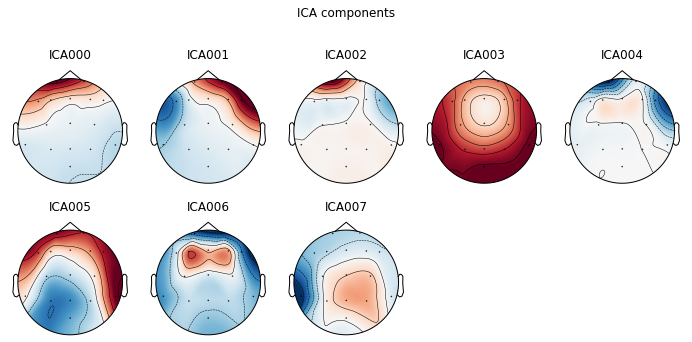

In [20]:
ica.plot_components();

### Plot IC properties

We can use the `.plot_properties()` method of the ICA class to view more details of each IC. Moving clockwise from top left, the four subplots for each IC are:
- topo map
- raster plot of how the IC weights on each trial. Artifacts like blinks should appear as "streaks" lasting about 200-300 ms, on relatively few trials. Components reflecting brain activity are typically present across many epochs (although remember that these data are segmented into 1 s epochs across the entire raw data set, so we would not expect to see time-locked activity here)
- Variance of the component, across channels and time. The *x* axis is epochs (effectively, time across the experiment), and the *y* axis is the variance of the IC across channels. Noise typically manifests as high variance on a low number of trials, and low variance on most trials, or lots of variability in the values on the *y* axis over epochs. True brain activity usually appears as consistently similar — and low — variance across epochs. 
- The PSD (phase spectral density) of the IC. EOG (eye) artifacts will typically have a peak at the low frequency end of the spectrum (the left side of the *x* axis), and muscle artifact will tend to show increasing power at the high end of the frequency spectrum (the right side of the *x* axis).  


With this in mind, `ICA000` is very characteristic of a blink artifact. The scalp topography is weighted most heavily at the electrodes right above the eyes (where blinks are most strongly detected) and the raster plot shows horizontal "streaks" on relatively few trials. The third plot shows high variance on a few trials, and the PSD is largest at the low end of the spectrum. 

`ICA001` shows similar properties, except that its scalp topography is maximal over the left and right anterior scalp locations, with opposite polarities (showing as blue vs. red). This is characteristic of horizontal eye movements.

Some of the other ICs may also be attributable to noise rather than EEG activity — for example ICs 4, 6, and 7. However, since these are not clearly well-defined ocular artifacts, we will not remove them. It is better to be conservative in terms of not removing too many ICs, than risking removing true brain activity.

Fortunately, as we'll see below, we don't necessarily need to make subjective judgment calls about which ICA components to reject (although some researchers do use visual inspection, based on extensive training and experience). There are automated algorithms that attempt to do this objectively. However, it's worth knowing what artifacts look like, so that you can check the results of any automated approach to ICA component selection/rejection against your understanding of how they should work. Indeed, as we will see below, these automated algorithms are not always perfect.

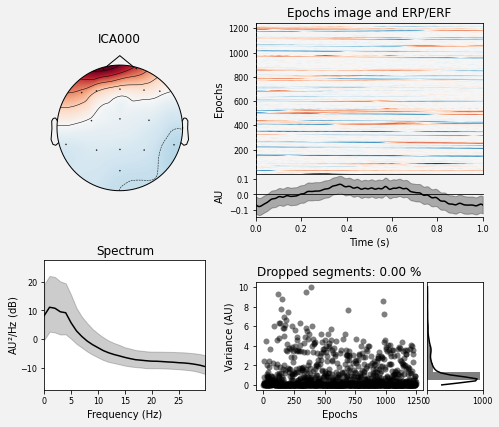

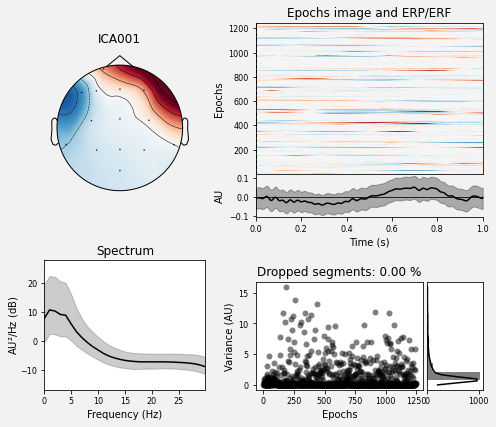

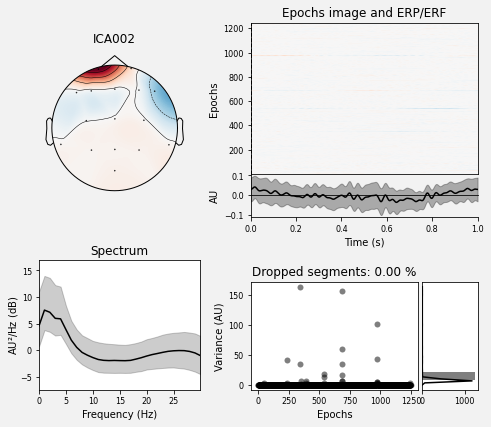

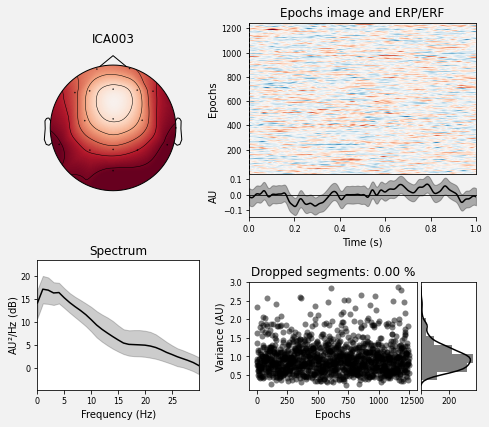

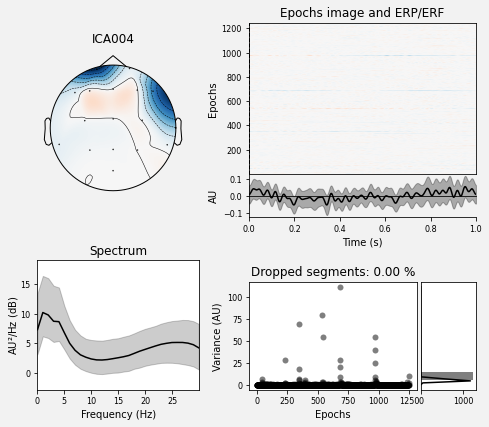

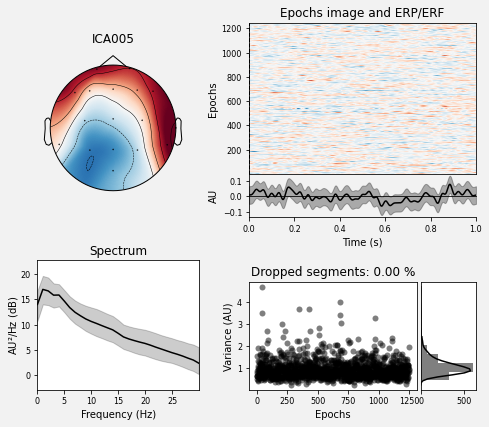

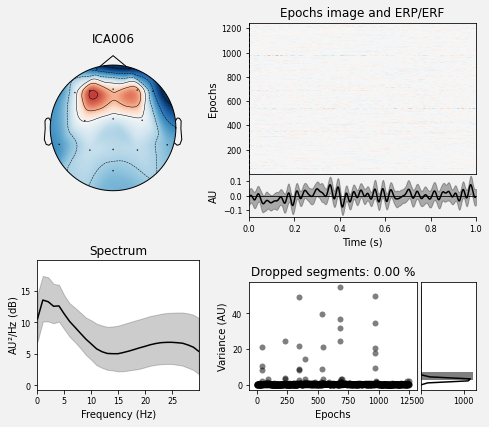

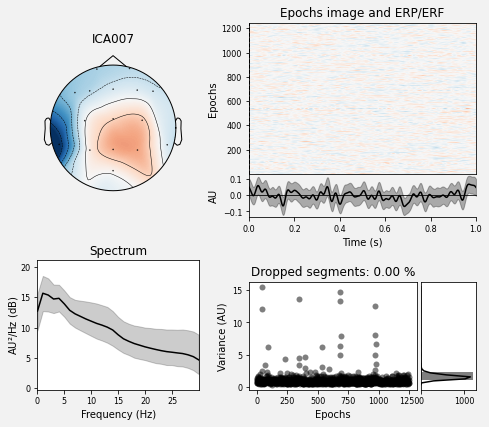

In [21]:
ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': hi_cut});

### Identify EOG artifacts from ICA components

MNE has an algorithm that attempts to automatically identify ICA components. The `find_bads_eog()` function computes correlations between each IC and channels that the researcher has designated as **EOG** (electro-oculogram) channels. These are electrodes, the same as EEG electrodes, but intentionally placed close to the eyes specifically to monitor for blinks and eye movements. These are typically placed above and below one eye (to monitor blinks and vertical eye movements, as well as on the temples of the head laterally to the eyes (to monitor horizontal eye movements).

In the present data set, unfortunately EOG was not recorded. However, the Fp1 and Fp2 electrodes are above the eyes, and F7 and F8 are close enough to the sides of the eyes to detect horizontal movements. `find_bads_eog()` takes a `ch_name` kwarg to allow us to specify EEG channels that we want to use in place of EOG channels; below we use Fp1 and F8 (we only need one channel each for blinks and horizontal movements). We add another kward to override the default correlation threshold of `find_bads_eog()` which, in my experience, does not work well for EEG data (although it does for MEG data) and use instead *z* > 1.96, which corresponds to a 5% chance of a correlation that large occurring due to chance.

MNE also provides a `.plot_scores()` method that will plot the correlation values for each IC, and mark any that were rejected in red.

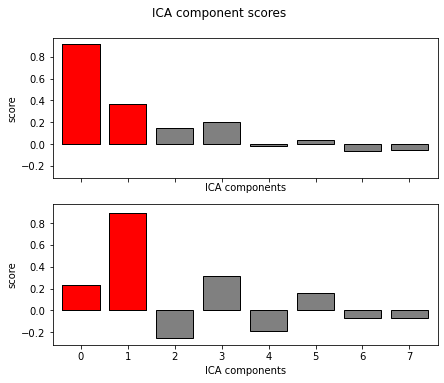

In [22]:
ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(raw_ica, 
                                            ch_name=['Fp1', 'F8'], 
                                            threshold=ica_z_thresh)
ica.exclude = eog_indices

ica.plot_scores(eog_scores);

## Segmentation into ERP epochs

### MNE's events structure

**Event codes** indicate when events of experimental interest occurred during the EEG recording. They are typically generated by the stimulus computer, and sent to the EEG recording computer at the same time that the stimuli are presented to the participant. Event codes may also mark when a participant made a response (such as a button press, or the onset of a vocal response), or other information such as the start of a new bock of trials or condition, rather than a specific stimulus. 

<div class="alert alert-block alert-info">

Event codes can also be generated by devices that detect when a stimulus occurs. For example, a light-sensitive *photodiode* can be used to detect when the brightness of a location on a computer screen changes. This setup can be useful in some situations, because sometimes there is an unpredictable delay between the time that the computer software initiates presentation of a stimulus, and when the hardware actually presents the stimulus. These delays are typically only on the order of a few, or possibly tens, of milliseconds, but that is enough to cause problems when averaging ERPs from multiple trials together — especially if the delay is inconsistent across trials. The result will be that the peaks and troughs of the waveforms do not align perfectly across trials, and the resulting averaged ERP will look more smoothed and less "peaky". Event codes can also be generated by devices that detect when a stimulus occurs. For example, a light-sensitive *photodiode* can be used to detect when the brightness of a location on a computer screen changes. This setup can be useful in some situations, because sometimes there is an unpredictable delay between the time that the computer software initiates presentation of a stimulus, and when the hardware actually presents the stimulus. These delays are typically only on the order of a few, or possibly tens, of milliseconds, but that is enough to cause problems when averaging ERPs from multiple trials together — especially if the delay is inconsistent across trials. The result will be that the peaks and troughs of the waveforms do not align perfectly across trials, and the resulting averaged ERP will look more smoothed and less "peaky".
</div>

Segmenting the data into ERPs depends on these event codes, since they are what we time-lock to. To use them for ERP segmentation, we need to first extract the timing and identity of each code from the raw data, and store it in a NumPy array. Because event codes are numeric (for reasons explained below), we also need to define a mapping between these numbers and meaningful labels (such as what type of stimulus or experimental condition the code denotes). 

In [23]:
events, event_dict = mne.events_from_annotations(raw)

We can view the first 10 rows of the events array:

In [24]:
events[:10]

array([[    0,     0, 99999],
       [   20,     0, 10001],
       [59520,     0,     5],
       [59523,     0,     1],
       [60055,     0,   201],
       [60199,     0,     2],
       [61253,     0,     3],
       [63156,     0,     1],
       [63653,     0,   201],
       [63756,     0,     2]])

`events` is a NumPy array with 3 columns, and one row for each event code in the data. 

The **first column** contains the index of the event code in terms of the data array. Recall that the data were sampled at a rate of 500 Hz, meaning we have one sample (i.e., measurement) every 2 ms. So the values in the first column of `events` are not time measured in milliseconds, but "time" in terms of samples or data points. This is important to remember later, although MNE generally makes it easy to go between samples and more intuitive measures of time like milliseconds or seconds.

The **second column** is usually zero, but is intended to mark the end time off an event, if the event code was send to the EEG system for a period of time. In practice it is rarely used.

The **third column** is the event code itself, as an integer. We'll elaborate later on what each code means.


<div class="alert alert-block alert-info">

Most EEG systems receive event codes from the stimulus computer using an electronic communications protocol called **TTL**, or transistor-to-transistor logic. It's very simple and low-level, and is done via the parallel port of a computer (which is so low-level, computers almost never have these build in anymore). The reason this arcane system is still routinely used in EEG is that its timing is very precise, which means it is the best option to get millisecond-level synchronization between when the stimulus computer presents a stimulus, and when the event code is received by the EEG system. This level of precision is vital in EEG research because the effects of interest occur on a millisecond time scale. The impact of this system for us is that the event codes stored in an EEG data file are usually restricted to integers in the range of 1–255, because that is the (8 bit) resolution of the TTL protocol (i.e., this kind of connection can inherently only send this range of values). Some EEG recording software allows the experimenter to specify text labels for each numerical event code, based on what the numbers mean in that particular experiment. However, in most cases mapping between the numerical event codes and meaningful labels is something we do in preprocessing, as shown below.

</div>

The second output, `event_dict`, is a dictionary mapping labels to the integer codes in the `events` array. The labels were created by the EEG recording software and stored in the raw file, but as you can see below they are mostly not very informative. We can see, however, that the first two codes in the `events` array above simply mark the start of the recording (*actiCAP* is the name of this EEG manufacturer's electrode system).

In [25]:
event_dict

{'Comment/actiCAP Data On': 10001,
 'New Segment/': 99999,
 'Stimulus/S  1': 1,
 'Stimulus/S  2': 2,
 'Stimulus/S  3': 3,
 'Stimulus/S  4': 4,
 'Stimulus/S  5': 5,
 'Stimulus/S  7': 7,
 'Stimulus/S101': 101,
 'Stimulus/S102': 102,
 'Stimulus/S111': 111,
 'Stimulus/S112': 112,
 'Stimulus/S201': 201,
 'Stimulus/S202': 202,
 'Stimulus/S211': 211,
 'Stimulus/S212': 212}

We will need to create our own dictionary of mappings between the integer event codes and meaningful names based on the design of our experiment. 

### Experimental design

This data set was collected while the participant viewed a series of pictures of objects on a computer screen. One second after each picture was presented, a spoken word was played over a speaker. The word was either the name of the pictured object, or some other word. Based on prior research, we predicted an **N400** ERP component for the mismatch trials relative to those on which the picture and word matched.

The N400 is a component first discovered by [Kutas & Hillyard (1980)](https://dx.doi.org/10.1126/science.7350657), in response to sentences that ended in a word whose meaning was not predicted given teh preceding words in the sentence. For example, the sentence *I take my coffee with milk and dog.* would elicit an N400 at the word *dog*. More than 40 years of subsequent research has shown that the N400 is a marker of brain processes involved in integrating new information into an ongoing context that people maintain of words and concepts — or in technical terms, *semantic integration*. Violations of expectations related to the meaning of stimuli evoke an N400 response. In the present experiment, we did not use sentences, however each picture created a context and the subsequent word either fit (matched) or did not fit (mismatched) that context. 

Although there were really only two experimental conditions in this experiment (match and mismatch), as you  there are a lot more than two event codes in the `events` array and `events_dict` dictionary above! This is because in this study, the experimenters coded details of the stimuli in great detail. This is common in research, where we have one central research question, but perhaps other questions relating to more fine-grained details of the stimuli. As well, the stimuli may vary in ways that are not of experimental interest, but are properties that we would like to control for. For now we will label each event code 

### Label Event Codes

We can define a dictionary that maps labels onto each event code of interest. As you can see below, there are 4 event codes associated with Match trials, and 4 associated with Mismatch trials. Later we will merge them before examining the ERPs, but for now we will label each one separately. This preserves the more detailed information, in case later we decide we want to break the data down in a more fine-grained fashion.

In [26]:
event_mapping = {'PicOnset':1, 'RespPrompt':2, 'CorResp':3, 'IncorResp':4, 'RespFeedback':5,             
                 'Match/A':111, 'Match/B':211, 'Match/C':112, 'Match/D':212,
                 'Mismatch/A':101, 'Mismatch/B':201, 'Mismatch/C':102, 'Mismatch/D':202
                }

MNE's `viz.plot_events()` function will read an events array and plot the timing of event codes over the time, with different rows and colours for each event type. We have to pass the sampling rate (`raw.info['sfreq']`) as the second argument so that MNE knows how to convert the samples in the `events` array to units of time. We also pass `event_mapping` so that the plot has a meaningful legend.

This plot can be very useful to understand the timeline of an experiment, and also to confirm that the types and timing of event codes Control what was expected based on the design of the experiment. In the present experiment, all three sentence types were randomly intermixed, so the plot below is consistent with this. 

Note that it's not necessary to use `plt.subplots()` before running any MNE plot routine. However, in some cases, such as this one, MNE's default plot size is not optimal for what is being plotted, so `plt.subplots()` allows us to specify the figure size. Note that when we run the MNE plot command, we don't apply a Matplotlib axis method, but instead pass the `ax` pointer to the subplot to MNE's plot command using the `axes=` kwarg. Many of MNE's plotting commands support this kwarg, but not all (since some MNE plots actually create figures with multiple subplots).

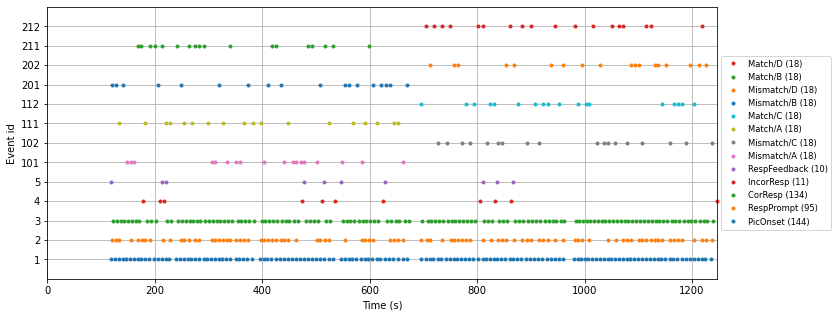

In [27]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw.info['sfreq'],  
                    event_id=event_mapping,                    
                    axes=ax)
plt.show()

### Segment the data into epochs

Finally, we split the continuous, filtered raw EEG data into epochs time-locked to the event codes of interest, as defined in `event_mapping`. To do this we use `mne.Epochs()`, which creates an object of the class `Epochs`. A number of arguments are necessary; the first 5 of these are *positional* arguments, meaning that the first 5 argument positions must have specific contents:
- the first is the raw data. We pass the filtered data.
- the next two arguments are the events array, and the mapping of events to labels
- the fourth and fifth arguments are the start and end times of each epoch (`timn` and `tmax`), relative to the event code. Typically the minimum (start) tie is a negative number, because for reasons explained below we want a *baseline* period to compare to the activity after the event code (typically 50-200 ms, but sometimes longer). The stop time depends on the timing of the ERP components you expect to occur. Some types of stimuli and experiments (such as studies of attention, or face processing) may only be interested in ERPs that occur within the first 500 ms after stimulus presentation. In language studies, interesting effects often occur up to 1 s or even longer after a word is presented. An important thing to note is that these times need to be specified in *seconds* (which is a bit counter-intuitive because we commonly talk about the timing of ERPs in milliseconds).

After these 5 required positional arguments, there are many kwargs we can specify. For our purposes, the defaults for most of these are fine. The one we will specify is `reject=`, which applies a threshold, in microVolts, for marking a trial as an artifact. This threshold was determined by the `get_rejection_threshold()` function earlier, and saved in the variable `reject`. This is used to remove excessive noise from the data set that can't be corrected with ICA. 

The `baseline` kwarg specifies what time period to use as the baseline for each epoch. The baseline is the period before the stimulus onset, and it is used to define "zero" voltage for each trial. This is necessary because  the measured electrical potentials can drift quite a lot over the course of the experiment (even after we filter out the lowest-frequency drift). So the absolute microVolt values for any given epoch might be rather different from other ones, due to drift. By subtracting the mean amplitude over the baseline period from each trial (and for each channel), we "centre" the measurements for that trial such that the potentials after the onset of each event code reflect the deviations of our measurements from the baseline period. Put another way, the measurements of each epoch reflect any changes in electrical potential that occur after teh event code, relative to the baseline period before it. We use `(None, 0)` for the baseline to specify the time period from the start of the epoch to the time of the event code.

We also include the `preload=True` kwarg. As with `raw` data, MNE tries to save memory by not keeping the epoched data in memory unless it is needed. However, below we will need it and so we force MNE to store this in the data here. 

The [`mne.Epochs` API](https://mne.tools/stable/generated/mne.Epochs.html) provides details on all the available kwargs (as well as all the methods that are defined for Epochs). 

In [54]:
# Epoching settings
tmin =  -.200  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (None, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_mapping,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True
                   ) 

If we ask for the value of `epochs` we get nice, tidy output with a summary of the contents of the data structure. 

In [40]:
epochs

Number of events,538
Events,CorResp: 134IncorResp: 11Match/A: 18Match/B: 18Match/C: 18Match/D: 18Mismatch/A: 18Mismatch/B: 18Mismatch/C: 18Mismatch/D: 18PicOnset: 144RespFeedback: 10RespPrompt: 95
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


Epochs can be accessed in a variety of ways, all using square brackets. 

If we use an integer, we get the epoch at that index position (epochs are numbered from zero to the total number of epochs, in the order the event codes occurred in the raw data):

In [30]:
epochs[0]

Number of events,1
Events,RespFeedback: 1
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


In [31]:
epochs[10:15]

Number of events,5
Events,CorResp: 1Mismatch/A: 1Mismatch/B: 1PicOnset: 2
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


We can alternatively access all of the epochs associated with a particular event code, using the label we assigned to the code using `event_mapping`:

In [32]:
epochs['Match/A']

Number of events,18
Events,Match/A: 18
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


These two methods can be combined to select a specific event out of those in a condition:

In [33]:
epochs['Match/A'][8]

Number of events,1
Events,Match/A: 1
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


If we pass multiple condition labels, then we will get all epochs in each of the conditions specified:

In [34]:
epochs['Match/A', 'Match/B']

Number of events,34
Events,Match/A: 18Match/B: 16
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


Usefully, MNE also recognizes the `/` separator for condition labels: the string before the `/` is treated as a more general category, with the string after the `/` treated as subsets of that category. What this means is that we can use only the string before the `/` to get all epochs from that category (all that have that string before the `/`):

In [35]:
epochs['Match']

Number of events,69
Events,Match/A: 18Match/B: 16Match/C: 18Match/D: 17
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


### Visualize average ERP across all conditions before artifact correction

We do this before removing ICs, so that we can compare with post-ICA below to see the effect of artifact removal.

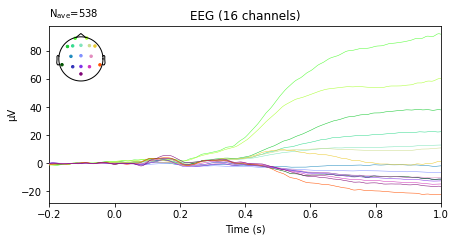

In [49]:
epochs.average().plot(spatial_colors=True);

The above plot shows strong evidence of ocular artifacts in the data: the amplitude scale is on the order of 100 µV, whereas real EEG is rarely more than 10–20 µV, and the largest amplitude values are in channels around the eyes (you can tell this by matching the colours of the lines in the plot with those of the channel locations on the inset showing the electrode layout).

### Scalp topography maps

As we did with ICA components, we can plot the EEG potentials over the scalp using the `.plot_topomap()` method. This will confirm that the artifacts are focused over the electrodes close to the eyes.

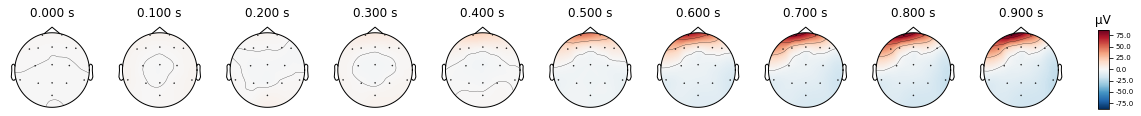

In [50]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs.average().plot_topomap(times=times, average=0.050);

### Apply ICA correction to epochs

To recap, we have created two different `Epochs` objects: 
- `epochs_ica`, with 1 s segments of the entire raw file, which we fit ICA on to identify artifacts
- `epochs`, with segments time-locked to each event code of experimental interest

Although we fit ICA to the `epochs_ica` data, we can actually *apply* this set of independent components to the `epochs` data. This is because ICA was fitted to the entire raw data set, and `epochs` is just a subset of that original raw data — so the effects of any ICs we marked for exclusion above will be removed from `epochs` with the `ica.apply` method. 

As with many MNE methods (such as filtering, as we saw earlier), the `ICA` `.apply()` method operates on data in-place, meaning it alters the data that is passed to it. In general, my preference is to make copies of data when applying transofrmations to the data, so here we chain the `.copy()` method.

In [56]:
epochs_postica = ica.apply(epochs.copy())

### Visualize average ERP across all conditions after artifact correction

Compared to the previous plot, we can see that artifacts have been successfully removed adn the data look more like typical ERP data:
- the large-amplitude deflections, largest at frontal channels, are no longer present
- the amplitude scale (*y* axis) is in the range typical of ERPs
- a series of early peaks typical of responses to visual stimuli are present (a first, small, peak around 75 ms, followed by a larger positive peak around 150 ms and a negative peak around 225 ms)

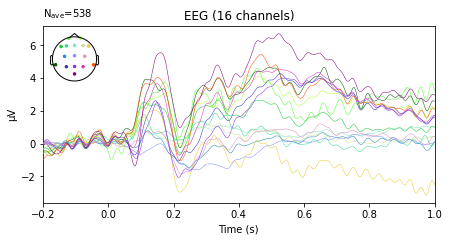

In [44]:
epochs_postica.average().plot(spatial_colors=True);

### Scalp topography maps

We saw this plot above, but now the scalp distribution of the electrical potentials shouldn't be concentrated over the eyes. 

We can also provide a bit more information about how these plots are drawn. We plot topo maps at 100 ms steps from the onset of the code up to the end of the epoch. The `average` kwarg specifies that each plot will reflect the average over a 50 ms time window, centered on each time point for which a plot is drawn. In other words, the plot labeled `0.100 s` reflects the average between 50–150 ms. 

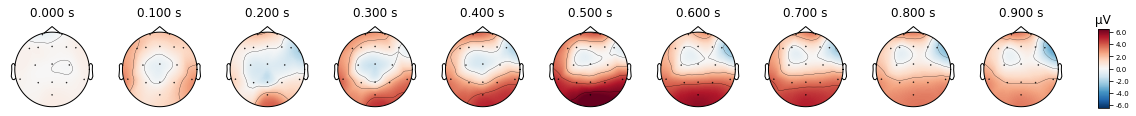

In [58]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs_postica.average().plot_topomap(times=times, average=0.050);

## Re-referencing

One thing that can be hard to get your head around at first, when working with EEG data, is that the electrical potential values at each electrode are actually *relative* measurements. Specifically, The microVolt measurement at each electrode is the *difference* in electrical potential at that electrode, relative to a **reference electrode**. This is actually a fundamental property of electrical potential measurements — they are always a relative measure. To understand why, we need to understand electricity a bit more.

Typically, when people think about electricity they think about the *flow* of electrical current through a conductor or device. For example, when you turn on a light switch, electrical current flows through the circuit (from a source, through wiring, to the light bulb, and then back into the building' wiring), creating illumination. However, when the light switch is off, the electrical circuit still has the *potential* for current to flow. A good analogy for this is to think about water, rather than electricity, because water is tangible and visible. If we place a bucket containing 10 L of water on a table, we have a *potential* for 10 L of water to move to some other location, such as the floor. If we connect a hose to an opening in the bucket, and run the hose down to the floor, we create a path through which the water can flow. Allowing the water to flow through the hose is equivalent to turning on the light switch in our earlier example — the flow of water is comparable to the electrical current flow. Note, however, that this example would not make sense if we held the bucket underwater in the ocean. If we did that, there would be no potential for water to flow out of the bucket, because it would be surrounded by water. In other words, when we say that a bucket on a table has potential for water to flow onto the floor, that's only because, in relative terms, there is 10 L more water in the bucket than on the floor.

Coming back to electricity, a closer example is the case of a battery, such as a standard AA battery. This has an electrical potential of 1.5 V. If it is placed in, say, a flashlight, and the flashlight is turned on, then current flows through the bulb and creates light. However, even with the flashlight turned off, the battery has 1.5 V of electrical potential. The way we would measure this potential is by connecting a device called a Voltmeter to either end of the battery (the *terminals*, marked `+` and `-`) — this would measure the difference in electrical potential between the two parts of the battery that would connect to an electrical circuit.

In all of these examples, we are measuring *potential* relative to some location/source that we treat as our reference. In the water example, there is 10 L more water on the table than on the floor. In the battery example, there is 1.5 V more electrical potential in the battery than in the device it's in, or the Voltmeter.

Coming back to EEG, when we measure electrical activity from the scalp, we are measuring the electrical potential at the location of the electrode, but it is necessarily relative to some other reference point. Ideally, we would have a reference point that is electrically neutral — that is, it has no electrical potential itself. However, this is technically challenging. For one thing, we want our reference point to be on the body of the person we are recording from, because otherwise we would be recording the difference in electrical potential between some external location and the *entire* body of the person (since bodies are ~80% water, with high electrolyte content, and are thus great conductors of electricity) which would include a lot of noise. In order to record only electrical activity in the brain, we need a reference point that is ideally on the head. 

It turns out that this reference location doesn't actually need to be "neutral" in the sense of not detecting any neural activity. Since electrical potential is a relative measurement, any pair of reference and measurement electrodes on the head will generate a measurement of the electrical potential difference between those locations. So as long as the reference electrode is not too close to the recording electrode, then we will get an electrical potential value. This is *not* to say that our choice of reference location doesn't matter, however. Indeed, the choice of reference location will determine the size and polarity (positive/negative) of the voltage measured at each recording electrode. We will demonstrate this below. 

The reason that this information is relevant to our preprocessing of the data, is that it is possible to **re-reference** the data after recording, to any other location where we had a a recording electrode. This is done simply be subtracting the electrical potential from the "new" reference electrode from the values at every other electrode, at each time point. This is useful because it means that we don't need to be too concerned about our choice of reference electrode location during recording. 

### What reference to select in preprocessing?

While the choice of reference during recording is somewhat arbitrary, the choice of what to use as a reference in preprocessing is, however, an important one. Since this choice will influence the amplitude values at each electrode, it will influence where ERP effects are identified, their polarity, and possibly how large they are.

A starting point for deciding on the re-referencing location is prior literature. In most areas of EEG/ERP research, there is an existing literature on the process and/or components of interest, and in many cases different research groups working on a topic will have converged on a common choice for reference location. Often this is a location that is relatively distant from the scalp location where the component(s) of interest are largest. For example, in face studies the nose, or bridge of the nose, are often used because this is far from the area behind the ears where the N170 ERP component elicited by faces is largest. In contrast, in studies of language, the mastoid processes (the bony area right behind the ears) is used as the reference because this location is far from the top of the head, where the N400 and other components associated with language procesing are largest. In this case, the potentials are averaged from the left and right mastoid locations, and then subtracted from every other electrode. This highlights another important consideration: since the brain is organized into two hemispheres, and many functions (such as language) tend to be lateralized to one hemisphere, it is good practice to choose a reference location that is either along the midline of the scalp (like the nose), or to average electrodes located over the left and right sides of the head.

### Average reference

An alternative to selecting a specific electrode(s) to re-reference to, is to use the average reference. In this case, the average potential across *all* electrodes is subtracted from each individual electrode. In principle, this is an ideal choice of reference because if all of the electrical activity recorded is from the brain, then the average electrical potential around the entire head should be zero. This is true because each source of electrical activity in the brain is an electrical *dipole*, with positive and negative values radiating out from the source in opposite directions. So, if we placed electrodes around the entire head with equal spacing between them, we would record the positive and negative potentials from each dipole source in the brain, and these would cancel out. However, in practice the situation is less ideal. Because of the fact that the head is attached to the neck (which we normally view as a Good Thing), we cannot place electrodes evenly around the entire head. Indeed, in practice EEG caps cover only the top half of the head, and typically a bit less than that. 

However, even in such less-than-ideal situations the average reference can be a good choice, because then the electrical potential at each scalp location reflects what is unique to that position on the head relative to all other positions (from which we have recordings). There are a few limitations of average reference to keep in mind though. 

For one, if the experiment is designed to elicit an ERP component that is known to be quite large and extensive over the head, the average reference may not be a good choice. For instance, some components such as the P3 and N400 tend to be largest over the top of the head, but extend outward across many more electrodes. So if the same component is present at all or most of the electrodes used, then an average reference will effectively subtract that component from the data.  

A related consideration is the number of electrodes used during recording, and their locations. Average reference will work best when more electrodes used, and when more of the surface area of the head is covered by these electrodes. More extensive coverage will mean that there is less likelihood that a widely-distributed component is subtracted in the average (because there will be more electrodes that aren't located over scalp regions where the component is present). More electrodes both allow for more extensive scalp coverage, and ensure that the average is not biased by a few electrodes that have large potentials — including electrodes that may contain noise. Noisy electrodes are an issue for average reference because the noise in one electrode will effectively be introduced into every other electrode, when it is used as a reference. 

### What reference was used in our data set?

Unfortunately, by default the reference location is not recorded in the raw data file, and so it is not something we can find in one of the attributes of the `Raw` data set. However, we know (since this data was collected in my lab, and we are always careful to document our procedures) that the reference electrode was located at the International 10-20 System position FCz, which is located along the midline of the scalp, halfway between electrodes Fz and Cz. The recording montage is shown below to allow you to visualize where this would be:

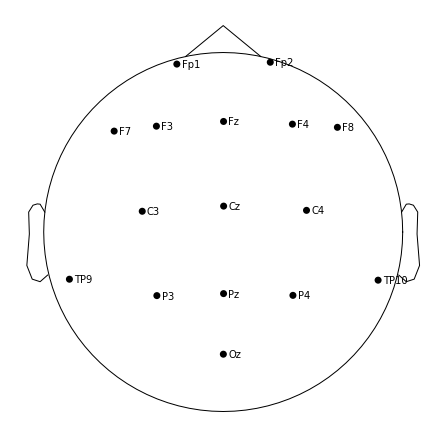

In [59]:
epochs_postica.plot_sensors(show_names=True);

The fact that the reference electrode was positioned between Fz and Cz explains why, in the raw data (re-plotted below), the traces for these electrodes are so much flatter than all the other electrodes - the difference in measured electrical activity between these recording electrodes and the reference are very small, because they are measuring almost the same brain activity:

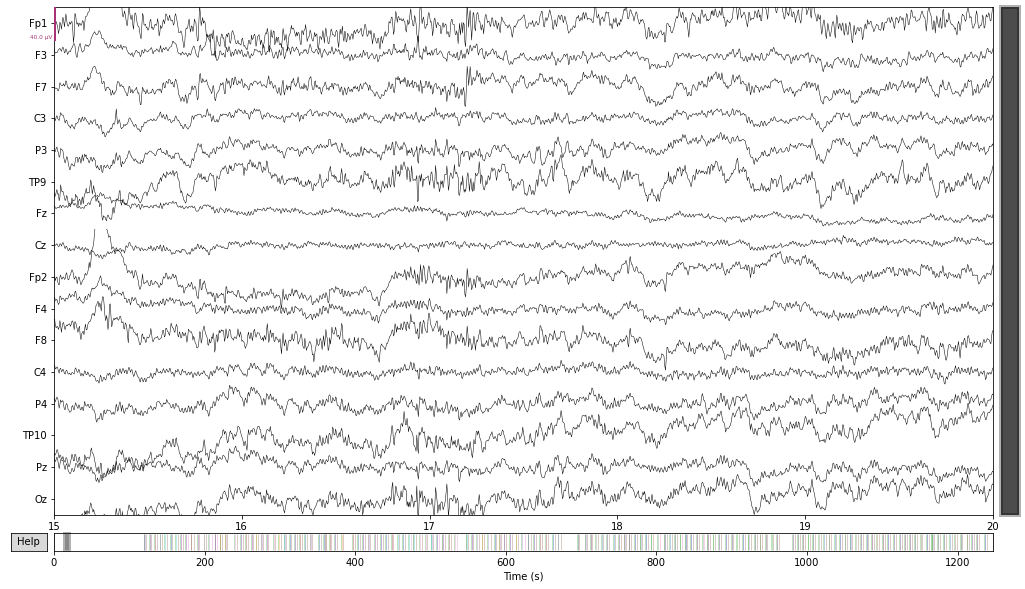

In [60]:
raw.plot(start=15, duration=5); 

The FCz reference location also explains why, in the scalp topography maps (re-plotted below), the area between electrodes Fz and Cz is white, or very close to it, at most time points. As communicated by the colour bar below, white represents a value of zero. The values aren't exactly zero/white in the plots below, because in generating these plots, MNE interpolates values in between the electrodes. In other words, we only have voltage measurements at each electrode (the dots in the plots), and the colours at every other location are determined by mathematical estimates of what the voltage values likely would have been, based on the values at the electrodes we do have. Since both Fz and Cz measure slightly different locations than the reference, they are not zero, and the estimated values between them may also not be zero due to noise. 

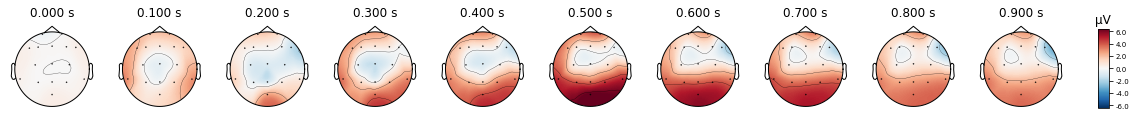

In [61]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs_postica.average().plot_topomap(times=times, average=0.050);

### Average reference

As noted above, the average mastoids are a common choice for N400 studies and we will use these below. But first we will demonstrate how to re-reference, and what the average reference looks like for this data set, as a way of understanding the effects of different reference location choices. Scalp topography maps are the best way to visualize the effects of re-referencing, since this procedure primarily affects the distribution of electrical potentials over the scalp.

MNE provides a `.set_eeg_reference()` method for this purpose. Here we chain this with a few other methods:
- first we average all the epochs together
- then we re-reference to the average of all electrodes
- then we plot the results as topomaps

Since we won't be using this data later, we don't assign the re-referenced data to a variable name, we just compute the average reference and plot it.

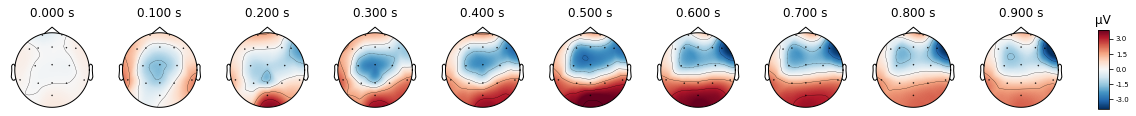

In [62]:
epochs_postica.average().set_eeg_reference(ref_channels='average').plot_topomap(times=times, average=.050);

Compared to the previous set of topomaps above, we can see that the average reference shows a large negative potential over the top of the head, especially around electrodes Fz and Cz. Notably, however, the overall distribution of electrical activity is similar between the original and average-referenced data. For example, the voltage at the back of the head is still positive relative to the top/centre of the scalp.

## Re-Reference the data to mastoids

Now we will re-reference to the average of the mastoid electrodes (whose labels are Tp9 and TP10 in the 10-20 system). Since this is the reference that we will want to work with, we assign the result to a new `Epochs` object, called `epochs_mastoidref`, and then plot it in a separate step.

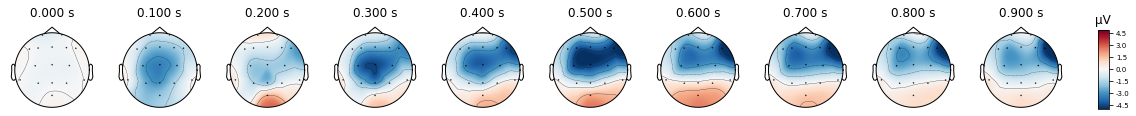

In [63]:
epochs_mastoidref = epochs_postica.set_eeg_reference(ref_channels=['TP9', 'TP10']);

epochs_mastoidref.average().plot_topomap(times=times, average=.050);

Again, the relative distribution of electrical potentials across the scalp is similar to the original and average-referenced data. However, now the white, "zero voltage" area overlaps the locations behind the ears, and the top/centre electrodes (extending to more frontal electrodes) are more negative than when other references were used. 

## Create ERPs for each condition

Since averaging across trials is typically the end goal of an ERP experiment, MNE has a distinct class, `Evoked`, for ERP data where multiple trials have been averaged for each experimental condition or trial type. Unlike `Epochs`, which by definition contain multiple trials and in which each trial has an associated condition label (event code), `Evoked` data sets are averages across trials for a *single* condition. Thus we have to create a separate `Evoked` object for each condition in our experiment. For convenience, we can store these in a dictionary, where the keys are the condition labels and the values are `Evoked` objects. 

In [64]:
conditions = ['Match', 'Mismatch']
# Create empty dict to append to
evokeds = {}

for c in conditions:
    evokeds[c] = epochs_mastoidref[c].average()
    
# Print out contents of evokeds dict    
evokeds    

{'Match': <Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~104 kB>,
 'Mismatch': <Evoked | '0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~104 kB>}

## Plot average ERP for each condition

We can use a method called `plot_joint()` to generate a combination of "butterfly" plots (waveforms of all electrode overlaid) and topographic maps at specific time points that we specify. This is a nice way of relating scalp topographies and waveforms. The time points specified for the topo plots were selected based on early peaks apparent in the waveforms above, and then on 200 ms intervals over the time period when teh N400 is expected:

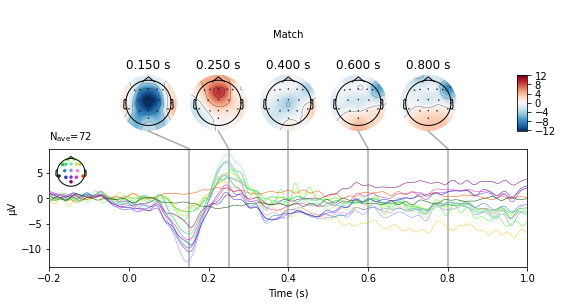

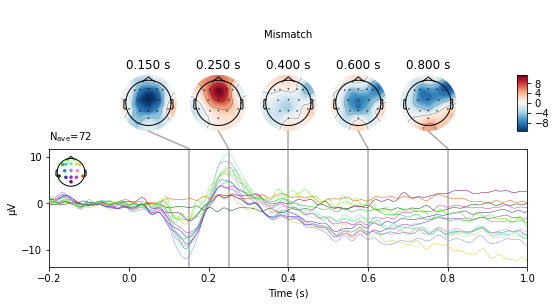

In [65]:
times = [.150, .250, .400, .600, .800]
for c in evokeds.keys():
    evokeds[c].plot_joint(times=times, title=c);

## Examine contrasts between conditions

Viewing the ERPs for each experimental condition is a good first step, but ultimately any ERP experiment should be designed around *contrasts* between different conditions. In the present study, we are interested in the difference between match and mismatch items. We predicted an N400 component, which would be larger (more negative) for mismatch than match items. The N400 tends to be largest over the midline centre/posterior region of the scalp (when using averaged-mastoid reference). So here we will plot the data at electrode Cz, which typically shows the N400 effect. We use the function `mne.viz.plot_compare_evokeds()`, which plots waveforms for each of a list of evoked items that you pass to it:

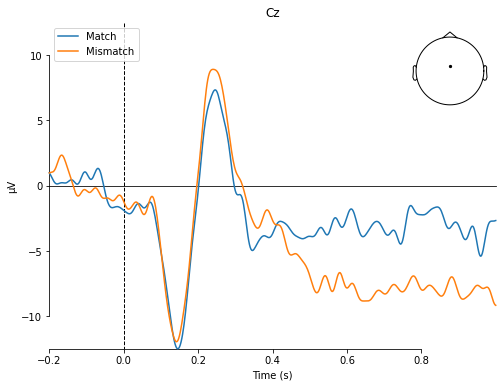

In [72]:
mne.viz.plot_compare_evokeds(evokeds, 
                             picks='Cz');

We can make this plot a bit nicer by adding a few things to it:
- firstly we define a *region of interest* (ROI) that includes a set of electrodes where the N400 is expected, so that we can plot the ERP waveform averaged over these electrodes
- we add the `combine` kwarg to tell MNE how to combine the data from these electrodes
- we define dictionaries mapping condition names to colours and linestyles for out plot, to make the two conditions' lines more distinctive
- we tell MNE where to put the legend and plot of the sensor locations, to ensure these don't overlap with the waveforms

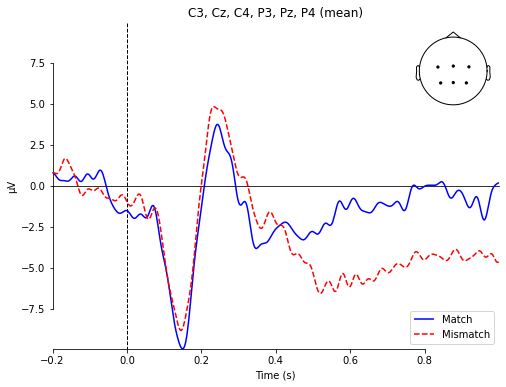

In [73]:
roi = ['C3', 'Cz', 'C4', 
       'P3', 'Pz', 'P4']

color_dict = {'Match':'blue', 'Mismatch':'red'}
linestyle_dict = {'Match':'-', 'Mismatch':'--'}

mne.viz.plot_compare_evokeds(evokeds, combine='mean', 
                             legend='lower right',
                             picks=roi, show_sensors='upper right',
                             colors=color_dict,
                             linestyles=linestyle_dict);

The N400 can be observed as the difference between the two conditions' waveforms starting just after 400 ms, and continuing to the end of the epoch. As predicted, the Mismatch waveform is more negative than the Match waveform during this period.

## Create difference waves 

Finally, we can create **difference waves** by subtracting the waveforms of our two experimental conditions. Since the N400 manifests as a larger negativity for mismatch, it is conventional to compute this difference as Mismatch - Match (otherwise the difference between the two would appear as positive, rather than negative, voltage). 

Computing difference waves allows us to view the experimental effect in a quite intuitive way: zero voltage means no difference between conditions, and and deviation from teh zero line in the waveform plot (or from white in the topopmaps) indicates an experimental effect.

MNE's `combine_evoked()` function allows us to combine Evoked data sets in different ways. To compute a difference, we pass the weights of `[1, -1]` to indicate we want to subtract the second Evoked data set listed (Match) from the first (Mismatch):

In [68]:
evokeds_diff = mne.combine_evoked([evokeds['Mismatch'], evokeds['Match']], 
                                             weights=[1, -1])
    
evokeds_diff

<Evoked | '(0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D) - (0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~104 kB>

Having saved this as a new Evoked object, we can plot it as a waveform.

We do a few extra things to make the plot more readable:
- Whereas before we simply passed the Epochs or Evoked data to the `plot_compare_evokeds()` function, here we pass a dictionary, where the key is the label we want to appear in the legend and the value is the Evoked data
- we add a `title` kwarg to give the plot an informative title

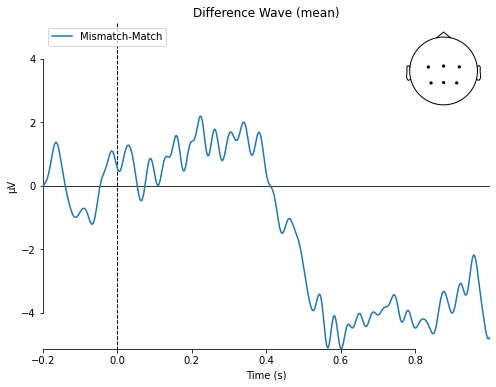

In [75]:
mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, 
                             picks=roi, show_sensors='upper right',
                             combine='mean',
                             title='Difference Wave')
plt.show()

One advantage of difference waves is that they make it very cclear when differences are occurring between conditions, and how large they are. When we compare waveforms for two conditions, the shape of the waveforms can sometimes make it hard to mentally compute the size of the difference - especially at time points when the waveforms' amplitudes are changing. In a difference waveform plot, the zero line clearly indicates no difference between conditions, and so the magnitude of the difference — as well as its timing — is easy to see. 

And we can plot the scalp distribution of the differences as well, which nicely shows the scalp distribution of the N400:

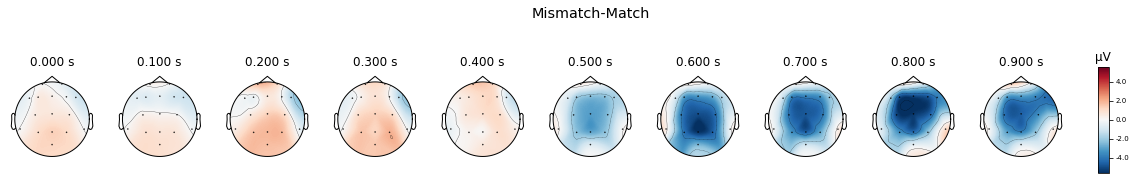

In [70]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

evokeds_diff.plot_topomap(times=times, average=0.050, title='Mismatch-Match');

## Summary

Preprocessing EEG data and deriving ERPs is a multi-step process. It's important to understand what each step does, why it's applied, and how to choose the correct parameters. 

There are a few additional steps that could be included in a preprocessing pipeline, that we have omitted here. For example, sometimes there there are *bad channels* — electrodes that had a poor connection throughout the recording, or were broken. There are ways to manually or automatically identify these and have them ignored throughout the preprocessing stream, and then *interpolate* data for these electrodes after artifact correction. 

After each individual participant's data has been preprocessed through a pipeline line this, the next step in analyzing an ERP experiment would be a group-level analysis. In a group-level analysis, the data from all participants would typically be averaged, and visualized using waveform plots and scalp topographic maps similar to the ones we've created here for one participant. 

As well, statistics can be applied. While there are many ways to do this, one of the most common ways for ERP studies is to average the data at each channel over a time period appropriate for the component of interest. For example, in this study a mean amplitude could be computed over the 600–800 ms time window, and then a 